# Preprocessing Part2  Jupiter Notebook: Extracting data from our csv and preparing it for the machine learning model
This is the second  preprocessing notebook. This notebook deals with processing the csv generated by the first notebook (preprocessed_data.csv) script,adds a new column called "Average Score" that displays the average score per each review and finally removes the "date column" as that is unneeded for this machine learning project.


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re

In [25]:
#first let's take a look at a general trend in the average score of reviews over time:
df=pd.read_csv("./data/preprocessed_data.csv")

#convert the dates into datetime:
df["Dates"]= pd.to_datetime(df["Dates"])

In [26]:
df.tail()

,Unnamed: 0,Dates,Comments,Customer Service,Satisfaction Reviews,Speed Reviews,Reliability Reviews,Average Score
4337,4337,2009-07-29,i pay for 20meg i usually get less than 10meg ...,1.430464,1.473697,2.194373,1.809791,1.727081
4338,4338,2009-07-29,I am very pleased indeed with our Virgin package.,1.430464,1.473697,2.194373,1.809791,1.727081
4339,4339,2009-07-29,Generally pretty good but for some reason very...,1.430464,1.473697,2.194373,1.809791,1.727081
4340,4340,2009-07-29,"Broadband speed below expected, considering mo...",1.430464,1.473697,2.194373,1.809791,1.727081
4341,4341,2009-07-29,supposed to be up to 10 mb its a question if I...,1.430464,1.473697,2.194373,1.809791,1.727081


Visualise the data over time to see if date is an important feature or not (I suspespect not)
The earliest reviews do not have any numbers (they were all missing data imputed by the algorithm, so for the purposes of our time analysis we shall only consider data dating back to june 2014):

In [27]:
start_date = '2014-06-07'
end_date   = '2022-11-15'
df2 = df.query('Dates >= @start_date and Dates <= @end_date')

Text(0.5, 1.0, 'Average Scores of Company Reviews from 07/06/2014 to 15/11/2022')

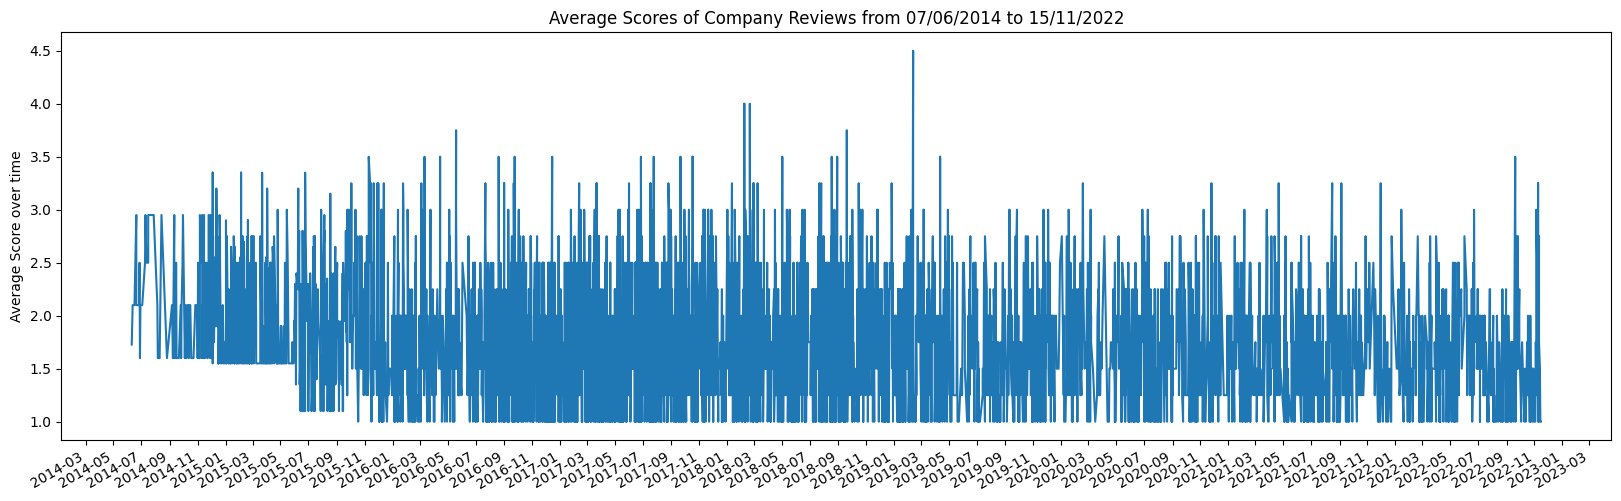

In [28]:
y_scores=np.array(df2["Average Score"])
fig, ax=plt.subplots(figsize=(20, 6))
sixth_year_locator = mdates.MonthLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%Y-%m") # four digits for year, two for month

ax.xaxis.set_major_locator(sixth_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter) 
ax.plot(df2["Dates"], df2["Average Score"])
fig.autofmt_xdate()
# beautify the x-labels

ax.set_ylabel('Average Score over time')
ax.set_title("Average Scores of Company Reviews from 07/06/2014 to 15/11/2022", fontdict=None, loc='center')

The  Average score does not seem to be directly related to time. It fluctuates periodically through out the years but overall it does not seem to be directly related to the average score of the reviews.. Thus we can safely drop this feature.

In [29]:
df.drop(["Dates", "Unnamed: 0"], axis=1, inplace=True)

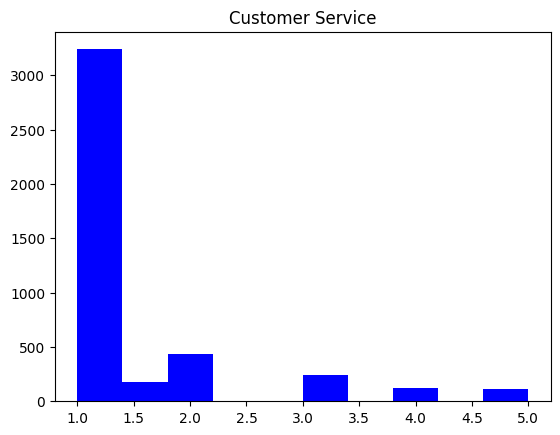

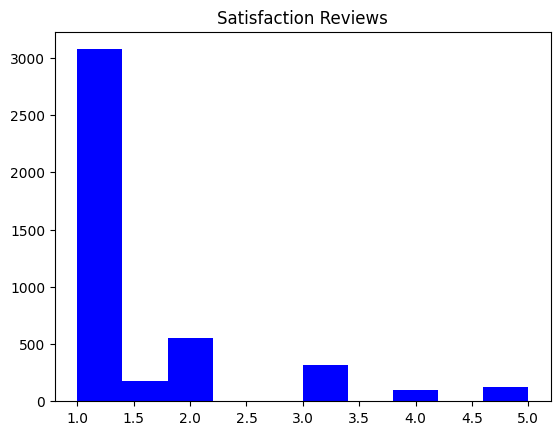

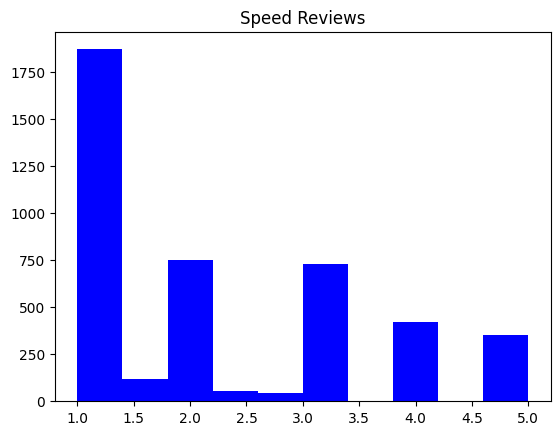

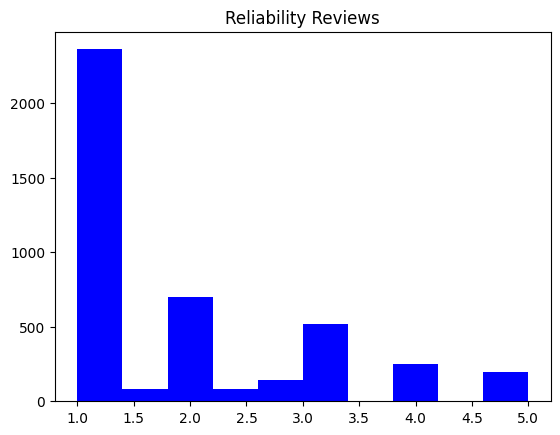

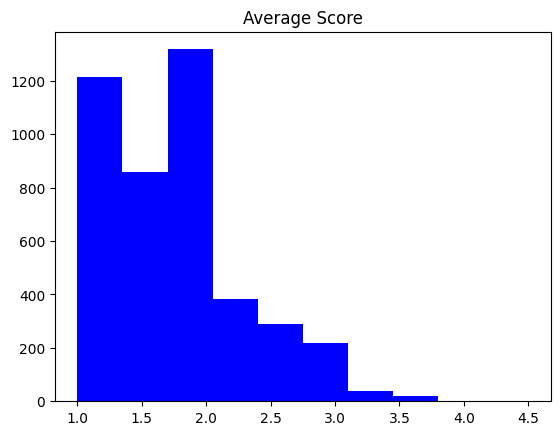

In [30]:
columns=list(df.columns)
for column in columns[1:]:
    plt.hist(df[column], color="blue")
    plt.title(column)
    plt.show() 

The histograms show that the majority of reviewers consider the service to be overall unsatisfactory as the majority of the reviews give it a less than satisfactory review.



This can indicate that the majority fo the text comments will be negative. So se will have a model that could get very good at predicting a bad review.

This is indicative that the company needs to improve its service towards customers (particularly its customer service, as that will influence the satisfaction reviews and reliability reviews (given that a customer service that is more responsive to customer queries and problems will result in a more satisfied clientele that will in turn perceive the company as more reliable))

However it must be said that the majority of people that leave reviews on  websites do so because they are unhappy (people like to rant and complain, fewer people like to praise a service) thus we can have a potentially unrepresented part of the clientele that is happy with the Company


# Preprocessing the Average Score comment

For our next part of the data processing, we are going to keep the average score column as that gives usa  good idea of the average review rating and drop the rest of the review score columns.

We will use the comment column to try and predict the value of the average score column.

In [31]:
df.drop(list(df.columns)[1:5], axis=1, inplace=True)


In [32]:
df.head()

,Comments,Average Score
0,Moved back to the UK end of August and got Vir...,1.00
1,"A truly attrocious service, both in terms of b...",1.00
2,They make it as hard as they can for you to ca...,1.50
3,Pay for the 350Mbps package but only ever mana...,1.75
4,The worst customer service:\r-The bots ask irr...,1.75


We are going to build a classifier model. For that we need to put the average scores into one of 5 classes one for each star rating: 1,2,3,4,5 so that each time that a comment is fed into a model, the model decides if it is a review that it is a 5 start review, a 4 one, a 3 one, a 2 one or a 1 star one.

To do this we are going to round each float in the Average Score review to the nearest integer:

In [33]:
df['Average Score']=df['Average Score'].round()

In [34]:
#let's check how many unique values we have now in our dataframe:
df["Average Score"].value_counts()

2.0    2819
1.0    1227
3.0     275
4.0      21
Name: Average Score, dtype: int64

# Preprocessing the Comments section

Next, we are going to address the comments column in our dataframe, and clean that. We will convert all text to lower case.
Remove symbols that are in BAD_SYMBOLS_RE from text, and finally remove any stop words.

In [35]:
import re #to filter symbols out
from gensim.parsing.preprocessing import remove_stopwords #to remove common words
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

lemmatizer = WordNetLemmatizer()

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
remove_chars=re.compile('/[!@#$%^&*]/g')
def clean_text(text: str) -> str:
    """
        text: a string
        
        return: modified initial string with non ascii characters, other special characters and stop words removed.
        Words are also converted to lower case and lemmatized.
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text=remove_chars.sub(" ", text)
    text = remove_stopwords(text)
    lemmatizer.lemmatize("rocks")
    return text

In [36]:
df['Comments'] = df['Comments'].apply(clean_text)

Remove non Ascii characters:

In [37]:
def remove_non_ascii(string: str) -> str:
    return ''.join(char for char in string if ord(char) < 128)

In [38]:
df['Comments'] = df['Comments'].apply(remove_non_ascii)

correct any spelling:

In [39]:
from textblob import TextBlob


def correct_sentence(text: str) -> str:
    
    """Corrects any spelling mistake in the sentences"""
    text= TextBlob(text)
    text=text.correct()
    return text

In [40]:
df.head()

,Comments,Average Score
0,moved uk end august got virgin media broadband...,1.0
1,truly attrocious service terms broadband custo...,1.0
2,hard cancel contract. phone 2 hours t o spend ...,2.0
3,pay 350mbps package managed 250mbps upload 34 ...,2.0
4,worst customer service: -the bots ask irreleva...,2.0


And our preprocessing of the text is now complete!  We now have preprocessed text that is ready to be fed into a dataframe

In [41]:
#save this preprocessed data into another csv for the model to access
df.to_csv('./data/data_ready_for_model.csv')